# Test 4
### Fit neural network based lens potential perturbations on a smooth SIE model and an elliptical Sérsic source.
The potential perturbation here is a single localised substructure on the Einstein ring.

__last update__: 20/07/21

In [1]:
# Basic imports
from time import time
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import optax  

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
from jax import jit, vmap

# Basic FLAX
from flax import linen as nn           
from flax.training import train_state  
from flax.core.frozen_dict import freeze

# JAX-ified lenstronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Util import image_util,models

# Universal font size
FS = 18

### Data grids (image plane and source plane)

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = [x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]]

# Lower resolution interpolation grid
npix_lowres = npix // 4
x_coords_lowres = np.linspace(extent[0], extent[1], npix_lowres)
y_coords_lowres = np.linspace(extent[2], extent[3], npix_lowres)
x_grid_lowres, y_grid_lowres = np.meshgrid(x_coords_lowres, y_coords_lowres)

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
                        'center_x': 0.4, 'center_y': 0.15}]

### Lens models (large-scale SIE + an SIE perturber)

In [4]:
# True lens mass model
true_lens_mass_model_list = ['SIE', 'SIE']
true_lens_mass_model = LensModel(true_lens_mass_model_list)
kwargs_true_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                         {'theta_E': 0.25, 'e1': 0.0, 'e2': 0.0, 'center_x': 1.9, 'center_y': -0.4}]

# Hybrid lens mass model
hybrid_lens_mass_model_list = ['SIE', 'NETWORK']
hybrid_lens_mass_model = LensModel(hybrid_lens_mass_model_list)


# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

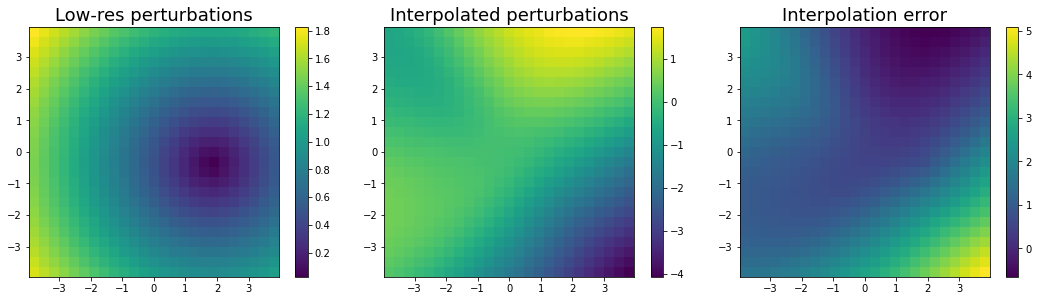

In [5]:
# Extract the true perturbation potential on original and low-res grids
psi_grid_true = true_lens_mass_model.potential(x_grid, y_grid, kwargs_true_lens_mass, k=1)
psi_grid_true_lowres = true_lens_mass_model.potential(x_grid_lowres, y_grid_lowres, kwargs_true_lens_mass, k=1)

# Set the hybrid lens mass model parameters (initialize network params and optimizer)
rng = jax.random.PRNGKey(8)
rng, init_rng = jax.random.split(rng)
state = models.create_train_state(init_rng,learning_rate=0.01,input_size=2,hidden_sizes=(100,100,1))
kwargs_hybrid_lens_mass = [kwargs_true_lens_mass[0],{'state':state.params}] 

# Random prediction (network not trained yet)
psi_grid_interp = hybrid_lens_mass_model.potential(x_grid_lowres, y_grid_lowres, kwargs_hybrid_lens_mass,k=1)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
img1 = axes[0].imshow(psi_grid_true_lowres, origin='lower', extent=extent)
axes[0].set_title("Low-res perturbations", fontsize=FS)
img2 = axes[1].imshow(psi_grid_interp, origin='lower', extent=extent)
axes[1].set_title("Interpolated perturbations", fontsize=FS)
img3 = axes[2].imshow(psi_grid_true_lowres - psi_grid_interp, origin='lower', extent=extent)
axes[2].set_title("Interpolation error", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

### PSF
Ignore the PSF for now.

In [6]:
kwargs_psf = {'psf_type': 'NONE', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Noise

In [7]:
# Noise
exp_time = 100
sigma_bkd = 0.05
kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)
noise_hybrid = deepcopy(noise)

### Image model

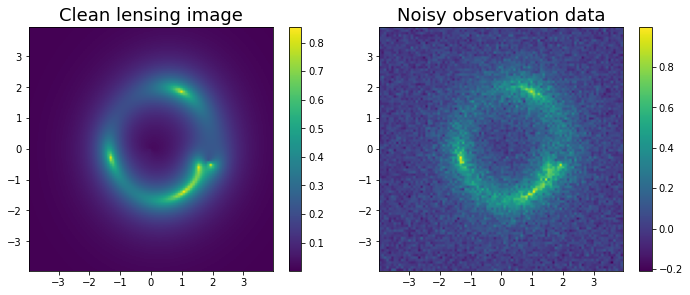

In [8]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
lens_image = LensImage(pixel_grid, psf,
                       noise_class=noise,
                         lens_model_class=true_lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image = lens_image.model(kwargs_lens=kwargs_true_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)


# Observed noisy data
data = lens_image.simulation(kwargs_lens=kwargs_true_lens_mass,
                             kwargs_source=kwargs_source_light,
                             kwargs_lens_light=kwargs_lens_light)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent)
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', extent=extent)
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

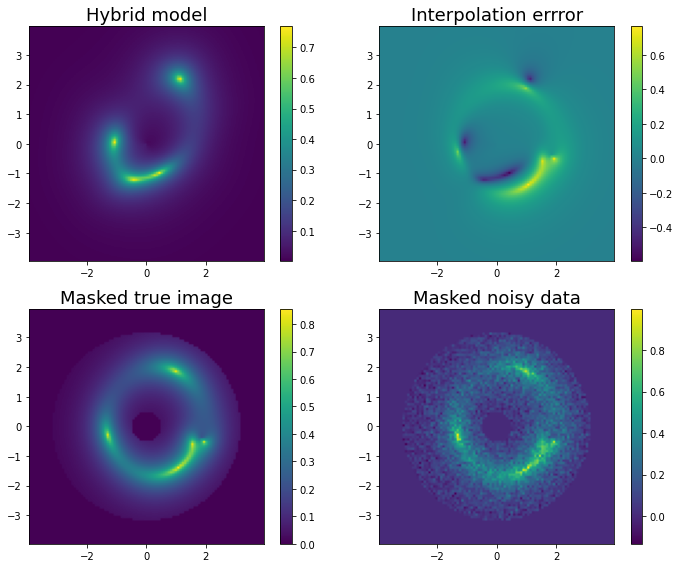

In [9]:
# Define a new noise class with true error map from the simulation above
kwargs_noise_hybrid = {'background_rms': sigma_bkd, 'noise_map': np.sqrt(lens_image.Noise.C_D)}
noise_hybrid = Noise(npix, npix, **kwargs_noise_hybrid)

# Hybrid image model for fitting
hybrid_lens_image = LensImage(pixel_grid, psf, noise_class=noise_hybrid,
                                lens_model_class=hybrid_lens_mass_model,
                                source_model_class=source_light_model,
                                lens_light_model_class=lens_light_model,
                                kwargs_numerics=kwargs_numerics)

# Test the hybrid model (results are gonna be bad since network is not trained)
hybrid_image = hybrid_lens_image.model(kwargs_lens=kwargs_hybrid_lens_mass,
                                        kwargs_source=kwargs_source_light,
                                        kwargs_lens_light=kwargs_lens_light)

# Generate a mask
rmin = 0.5
rmax = 3.2
# Original grid
radius = np.hypot(x_grid, y_grid)
mask = ((radius >= rmin) & (radius <= rmax)).astype(float)
# Low-res grid
radius_lowres = np.hypot(x_grid_lowres, y_grid_lowres)
mask_lowres = ((radius_lowres >= rmin) & (radius_lowres <= rmax)).astype(float)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
(ax1, ax2), (ax3, ax4) = axes
img1 = ax1.imshow(hybrid_image, origin='lower', extent=extent)
img2 = ax2.imshow(image - hybrid_image, origin='lower', extent=extent)
img3 = ax3.imshow(mask * image, origin='lower', extent=extent)
img4 = ax4.imshow(mask * data, origin='lower', extent=extent)
ax1.set_title("Hybrid model", fontsize=FS)
ax2.set_title("Interpolation errror", fontsize=FS)
ax3.set_title("Masked true image", fontsize=FS)
ax4.set_title("Masked noisy data", fontsize=FS)
for img, ax in zip((img1, img2, img3, img4), np.ravel(axes)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

### Network training (temporarily outside the library)

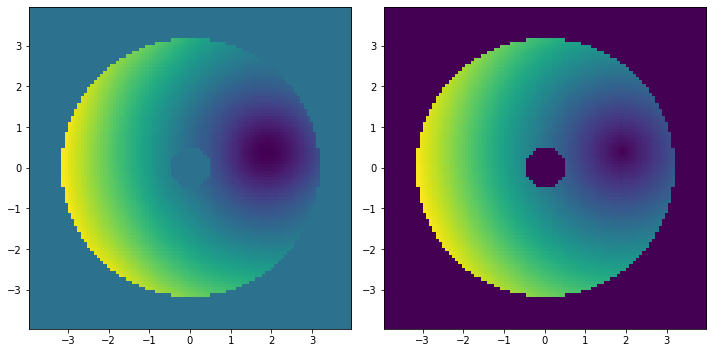

100
0.4176718013897652


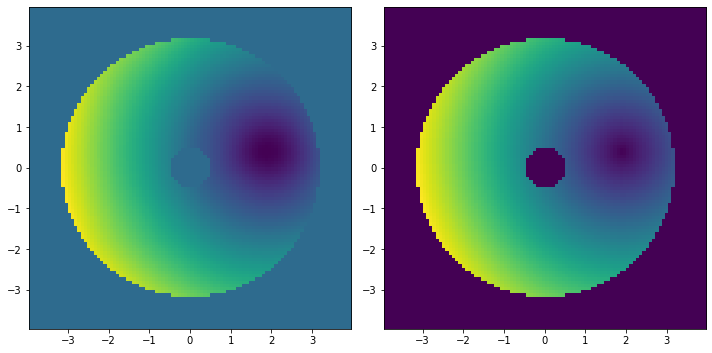

200
0.2923027327571406


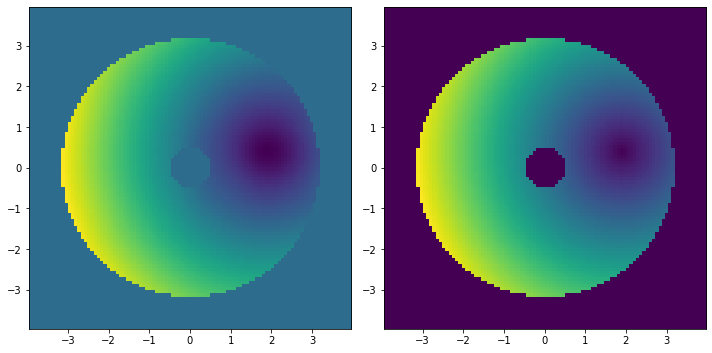

300
0.29567880701325555


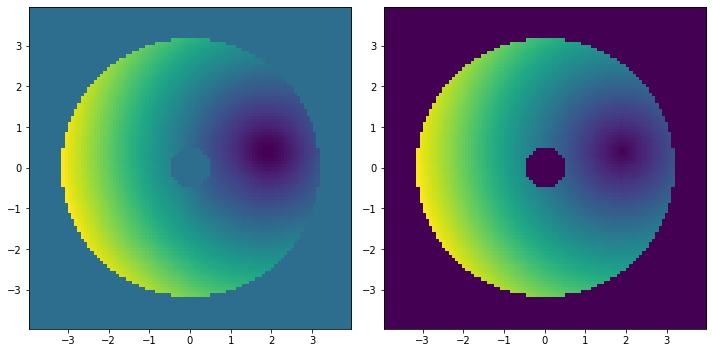

400
0.19505870961862737


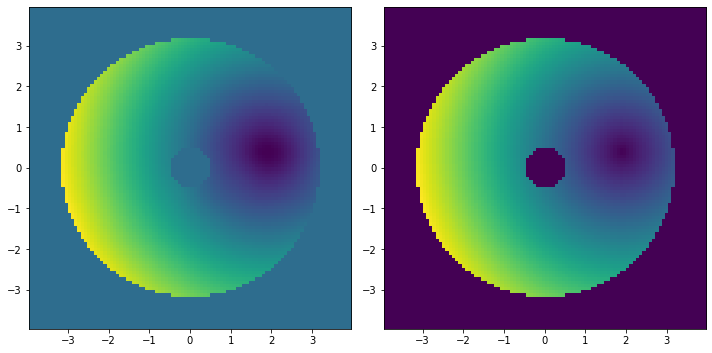

500
0.2055301755783048


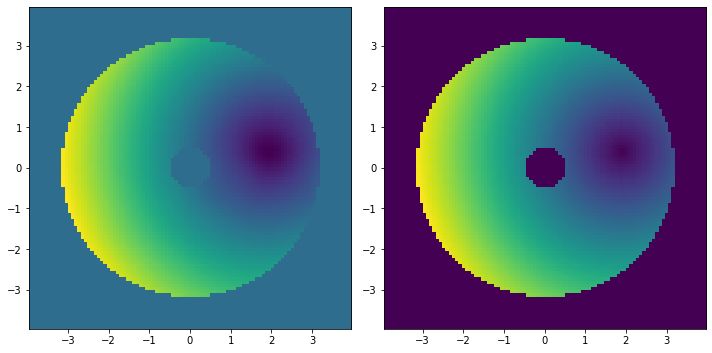

600
0.295847560692962


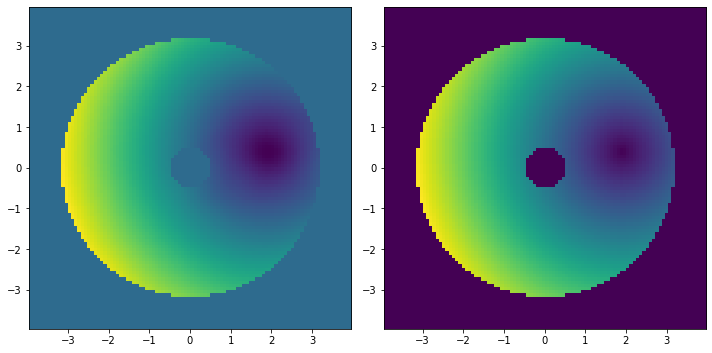

700
0.14364325356414995


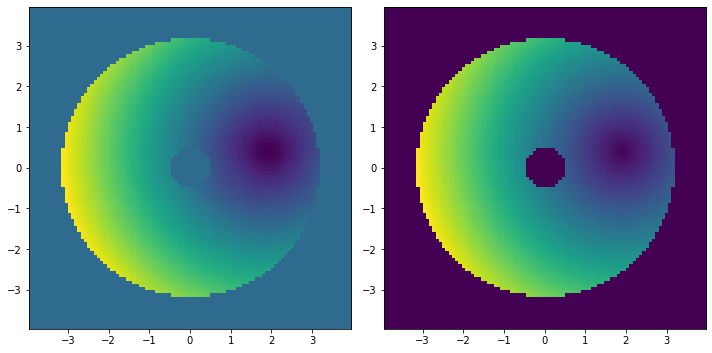

800
0.14766983033565934


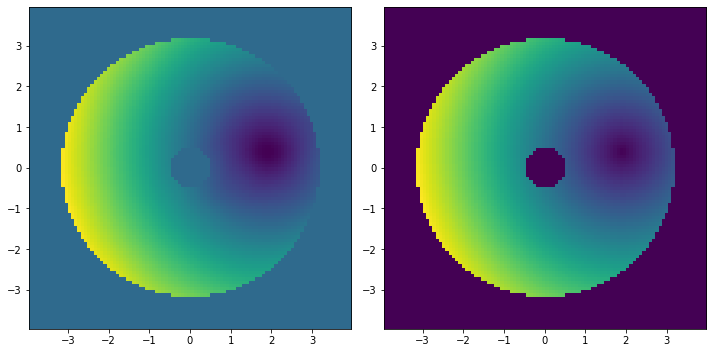

900
0.132732553600737


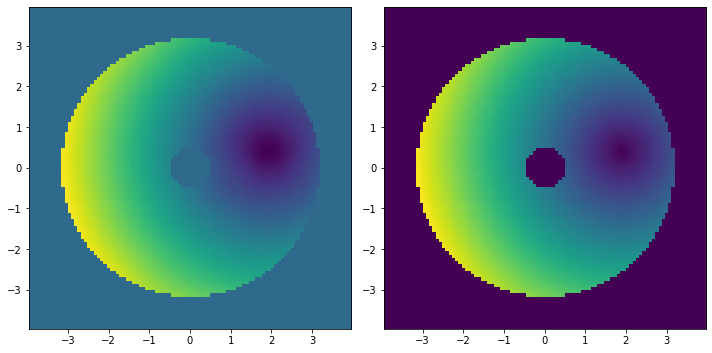

1000
0.20483625686586926


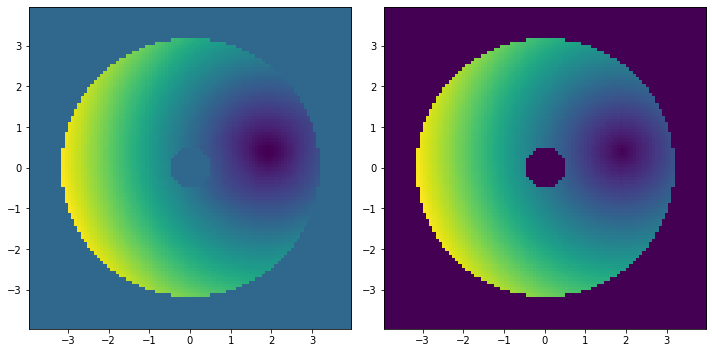

1100
0.13809950339855065


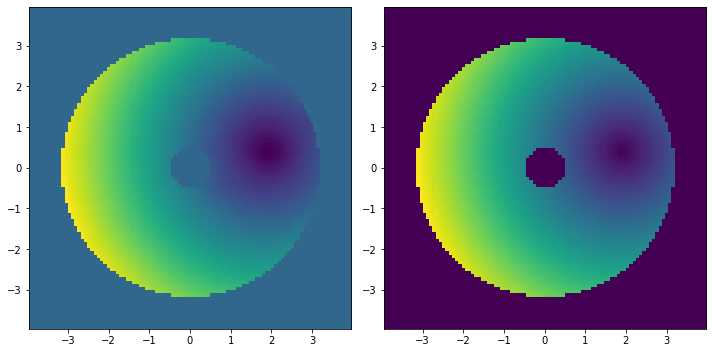

1200
0.1270149446259603


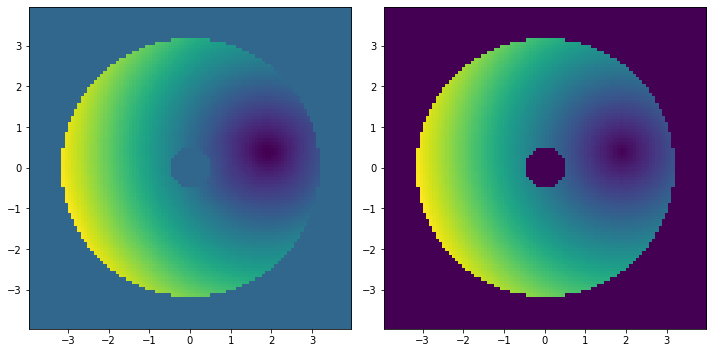

1300
0.1117066412959548


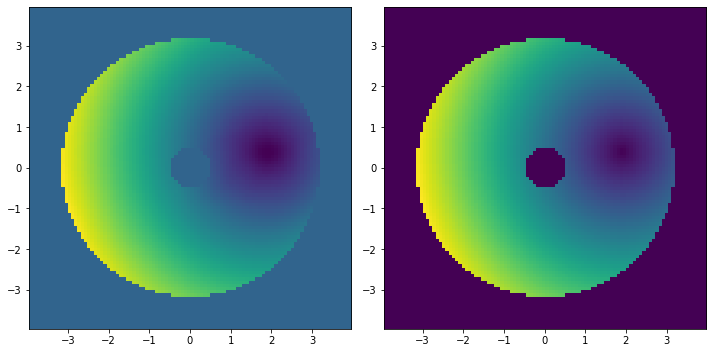

1400
0.13317105758132203


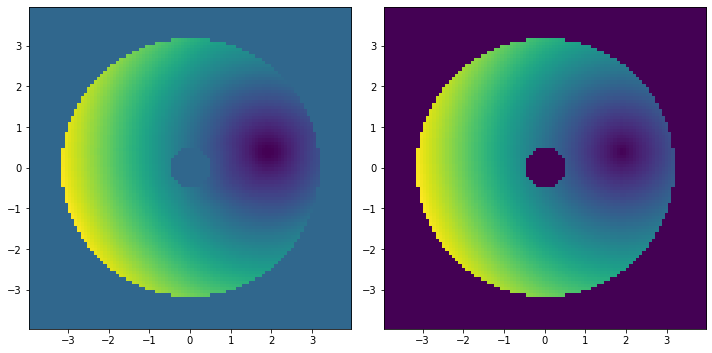

1500
0.10671633621490671


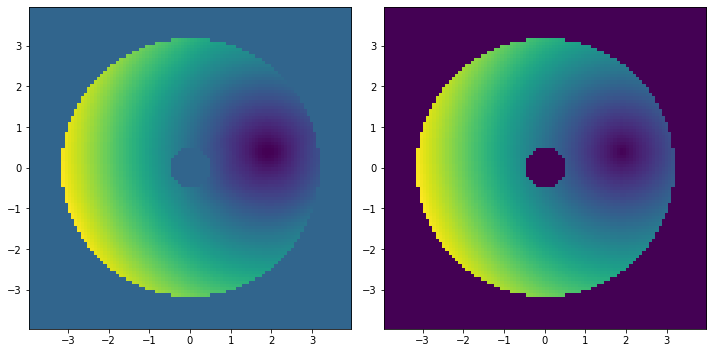

1600
0.08971203899021553


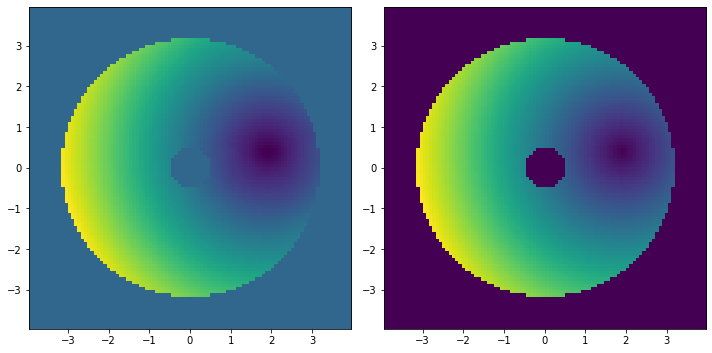

1700
0.10173294702536906


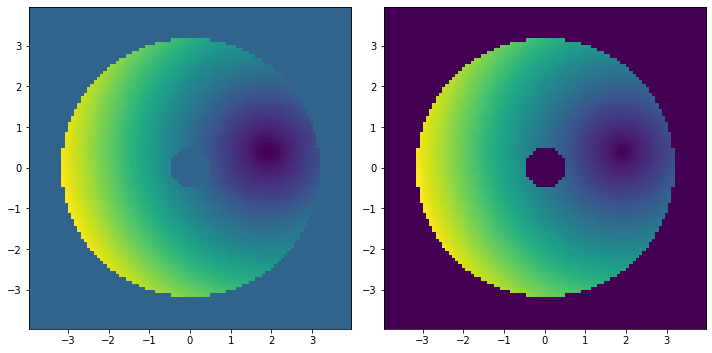

1800
0.08147450723901725


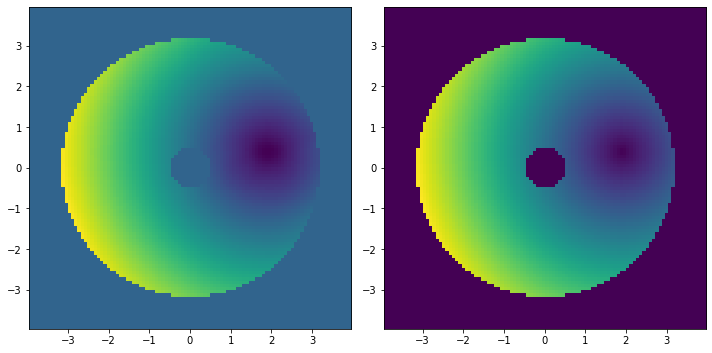

1900
0.07108892022215678


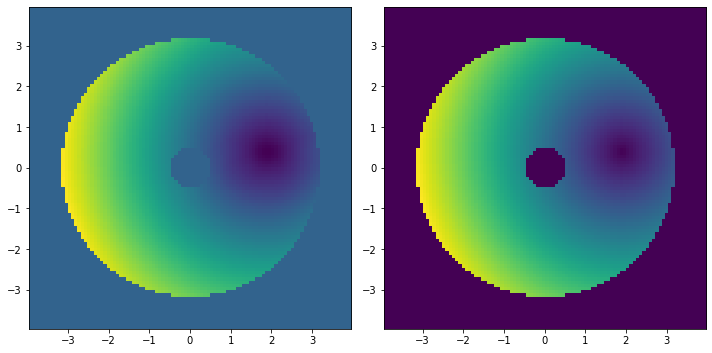

2000
0.08219996488695734


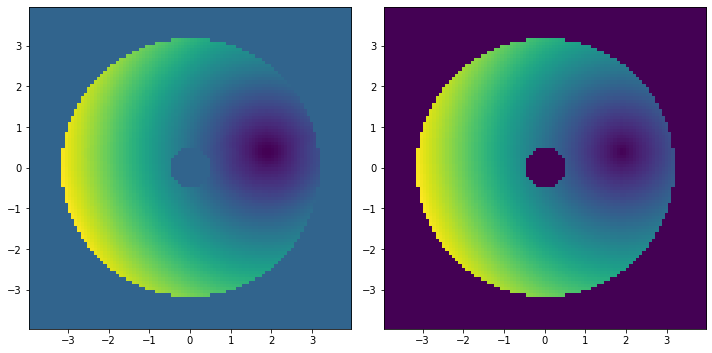

2100
0.07254664600619196


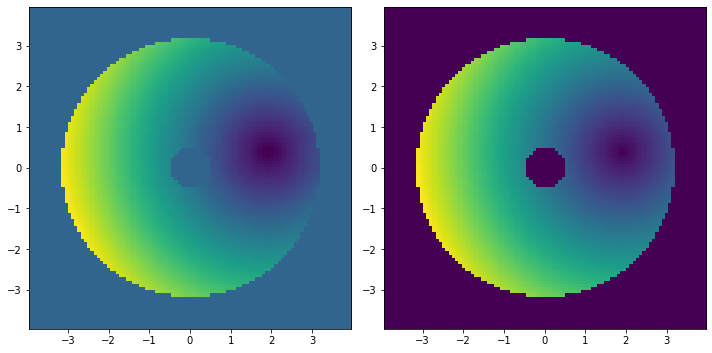

2200
0.08104783461033574


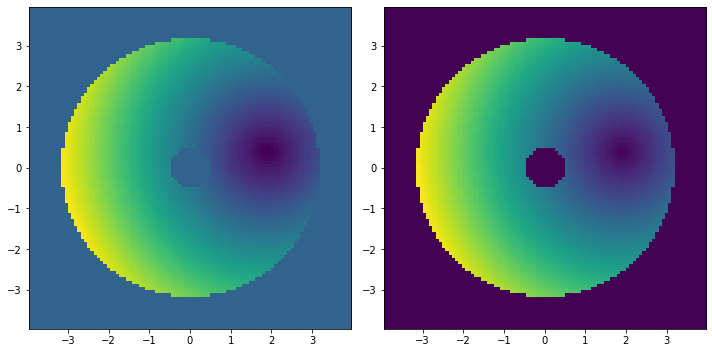

2300
0.07094541950042388


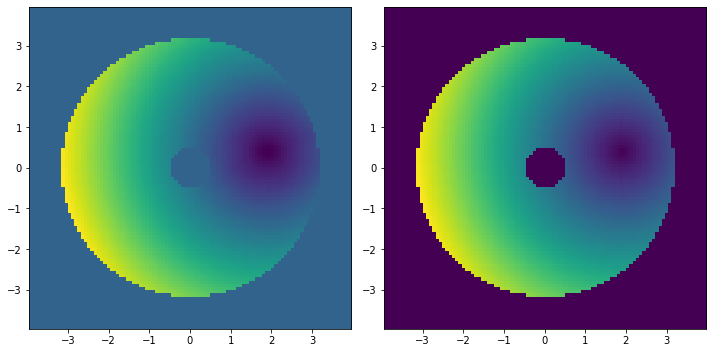

2400
0.05723516704757708


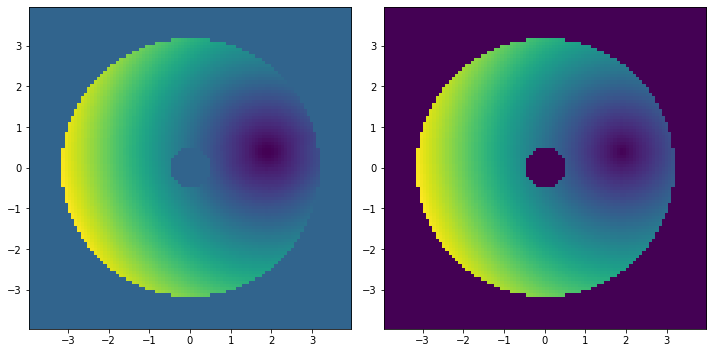

2500
0.05226887445955244


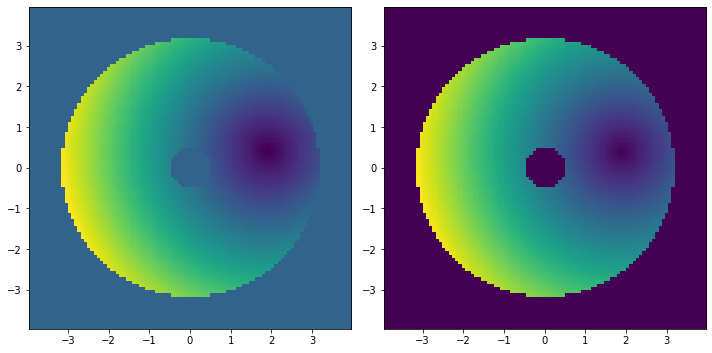

2600
0.09786386055764573


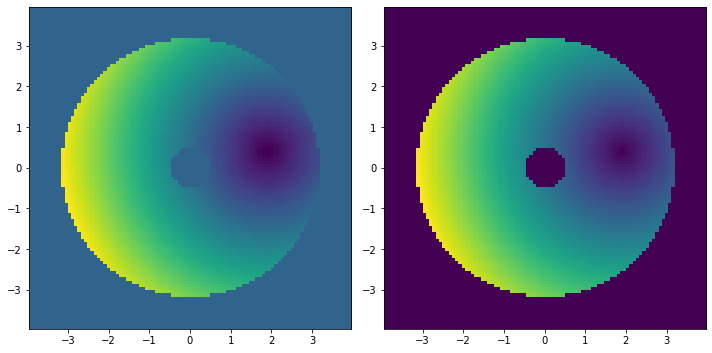

2700
0.054581725605599714


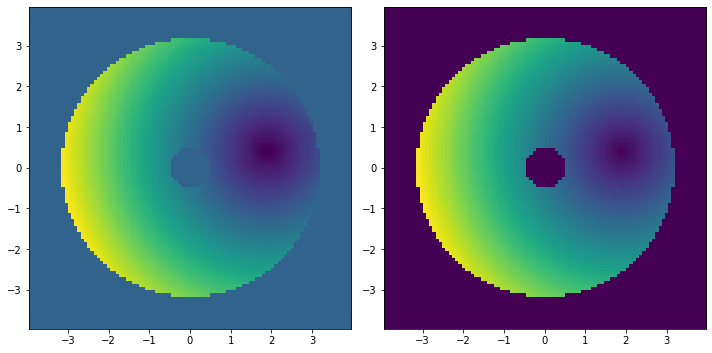

2800
0.052388751501772066


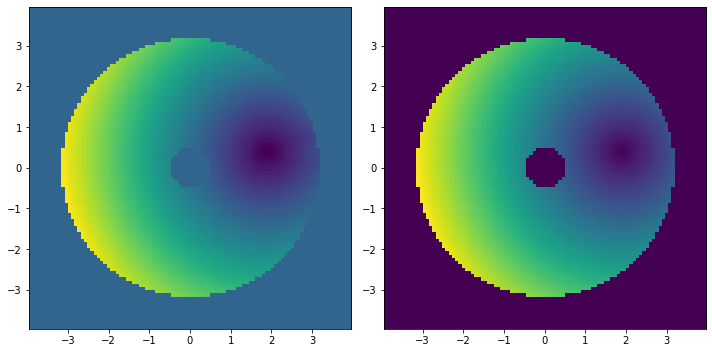

2900
0.09068469240147328


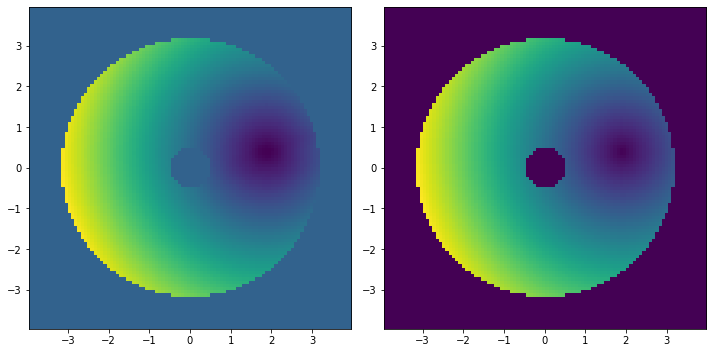

3000
0.08723808898132322
CPU times: user 6min 9s, sys: 4min 35s, total: 10min 45s
Wall time: 2min 5s


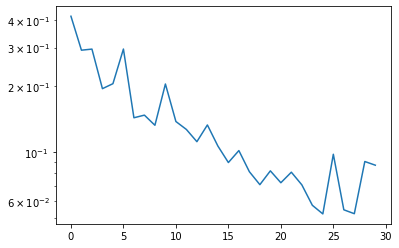

In [10]:
%%time
target=image   ###### data for noise-corrupted target, image for clean target
num_epochs=3000
trend=[]
#noise_add = noise.C_D #### handle likelihood variance
noise_add = 1. #### handle likelihood variance
for epoch in range(1, num_epochs + 1):
    rng, input_rng = jax.random.split(rng)
    state = hybrid_lens_image.train_step(state,target,noise_add=noise_add,
                       main_mass=kwargs_true_lens_mass[0], kwargs_source=kwargs_source_light,kwargs_lens_light=kwargs_lens_light)
    if epoch % 100 == 0:
        kwargs_hybrid_lens_mass = [kwargs_true_lens_mass[0],{'state':state.params}] 
        psi_grid_interp = hybrid_lens_mass_model.potential(x_grid, y_grid, kwargs_hybrid_lens_mass,k=1)
        psi_grid_true = true_lens_mass_model.potential(x_grid, y_grid, kwargs_true_lens_mass, k=1)
        loss = hybrid_lens_image.eval_step(target, noise_add=noise_add,
                                main_mass=kwargs_true_lens_mass[0], kwargs_source=kwargs_source_light,kwargs_lens_light=kwargs_lens_light,params=state.params)
        trend.append(loss)
        fig, axes = plt.subplots(1, 2, figsize=(10, 8))
        (ax1, ax2) = axes
        img1=ax1.imshow((psi_grid_interp*mask),extent=extent)
        img2=ax2.imshow((psi_grid_true*mask),extent=extent)
        fig.tight_layout()
        plt.show()
        print(epoch)
        print(loss)

#plot loss obeer training
plt.plot(trend)
plt.yscale('log')

### Image with trained network

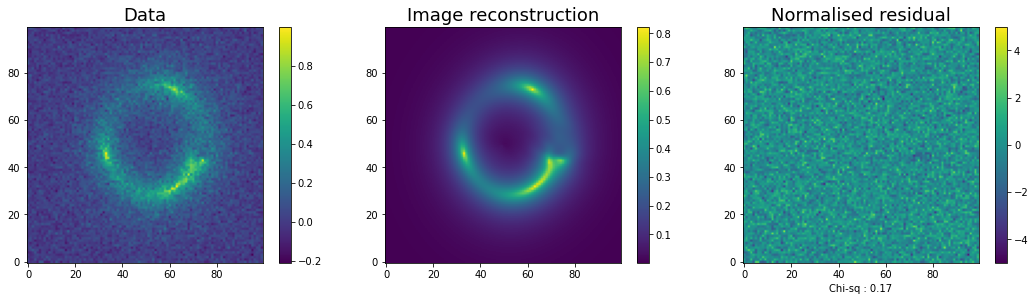

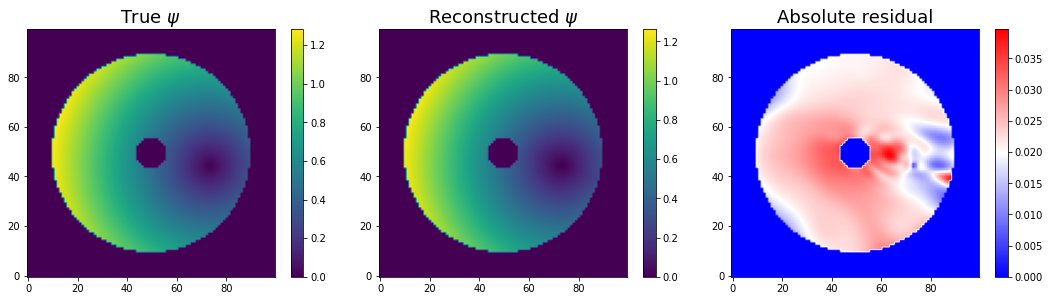

In [11]:
# create the resulting model image
hybrid_lens_image = LensImage(pixel_grid, psf, noise_class=noise_hybrid,
                                lens_model_class=hybrid_lens_mass_model,
                                source_model_class=source_light_model,
                                lens_light_model_class=lens_light_model,
                                kwargs_numerics=kwargs_numerics)
rec_image = hybrid_lens_image.model(kwargs_lens=[kwargs_true_lens_mass[0],{'state':state.params}],
                                                kwargs_source=kwargs_source_light,
                                                kwargs_lens_light=kwargs_lens_light)
noise_var = lens_image.Noise.C_D


fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(data, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(rec_image, origin='lower')
ax2.set_title("Image reconstruction", fontsize=FS)
img3 = ax3.imshow((data - rec_image) / jnp.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
ax3.set_title("Normalised residual", fontsize=FS)
ax3.set_xlabel(f"Chi-sq : {2 * loss:.2f}")
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()


psi_grid_interp_=psi_grid_interp+.4   ##### shifting factor needed
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(psi_grid_true * mask, origin='lower')
ax1.set_title("True $\psi$", fontsize=FS)
img2 = ax2.imshow(psi_grid_interp_ * mask, origin='lower')
ax2.set_title("Reconstructed $\psi$", fontsize=FS)
img3 = ax3.imshow((psi_grid_true - psi_grid_interp_) * mask, origin='lower', cmap='bwr')
ax3.set_title("Absolute residual", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()


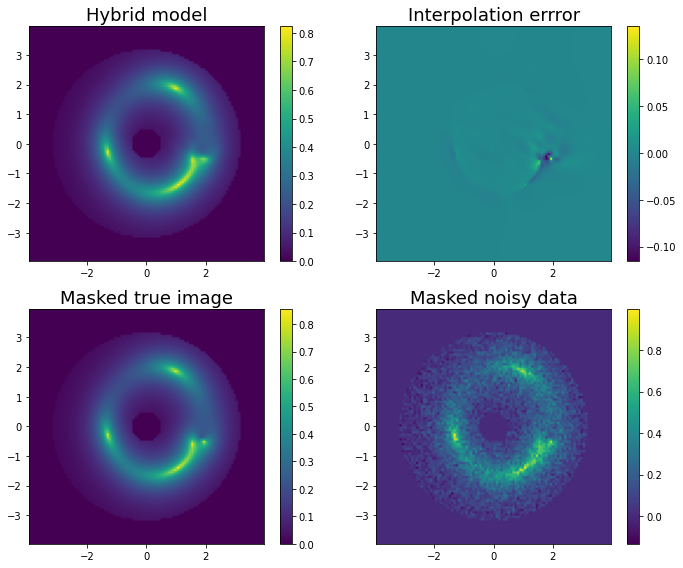

In [12]:
hybrid_image = hybrid_lens_image.model(kwargs_lens=[kwargs_true_lens_mass[0],{'state':state.params}],
                                        kwargs_source=kwargs_source_light,
                                        kwargs_lens_light=kwargs_lens_light)

# Generate a mask
rmin = 0.5
rmax = 3.2
# Original grid
radius = np.hypot(x_grid, y_grid)
mask = ((radius >= rmin) & (radius <= rmax)).astype(float)
# Low-res grid
radius_lowres = np.hypot(x_grid_lowres, y_grid_lowres)
mask_lowres = ((radius_lowres >= rmin) & (radius_lowres <= rmax)).astype(float)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
(ax1, ax2), (ax3, ax4) = axes
img1 = ax1.imshow(hybrid_image*mask, origin='lower', extent=extent)
img2 = ax2.imshow(image - hybrid_image, origin='lower', extent=extent)
img3 = ax3.imshow(image*mask, origin='lower', extent=extent)
img4 = ax4.imshow(data*mask, origin='lower', extent=extent)
ax1.set_title("Hybrid model", fontsize=FS)
ax2.set_title("Interpolation errror", fontsize=FS)
ax3.set_title("Masked true image", fontsize=FS)
ax4.set_title("Masked noisy data", fontsize=FS)
for img, ax in zip((img1, img2, img3, img4), np.ravel(axes)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

### Compare gt and predicted derivatives

Text(0.5, 1.0, 'y-partial derivative (gt)')

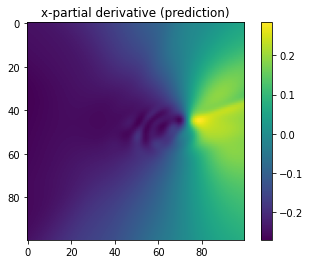

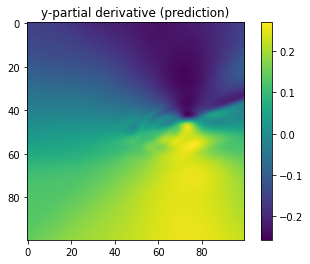

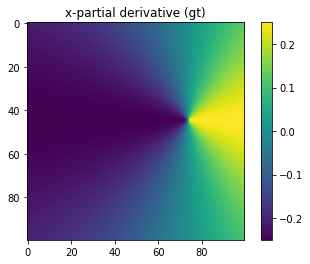

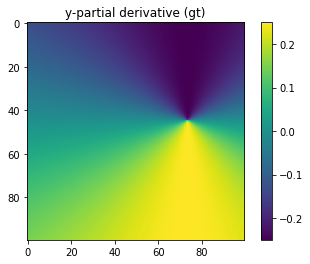

In [13]:
plt.figure()
plt.imshow(hybrid_lens_mass_model.alpha(x_grid, y_grid, kwargs_hybrid_lens_mass,k=1)[0])
plt.colorbar()
plt.title('x-partial derivative (prediction)')

plt.figure()
plt.imshow(hybrid_lens_mass_model.alpha(x_grid, y_grid, kwargs_hybrid_lens_mass,k=1)[1])
plt.colorbar()
plt.title('y-partial derivative (prediction)')

plt.figure()
plt.imshow(true_lens_mass_model.alpha(x_grid, y_grid, kwargs_true_lens_mass,k=1)[0])
plt.colorbar()
plt.title('x-partial derivative (gt)')


plt.figure()
plt.imshow(true_lens_mass_model.alpha(x_grid, y_grid, kwargs_true_lens_mass,k=1)[1])
plt.colorbar()
plt.title('y-partial derivative (gt)')